# Import modules and packages

In [1]:
%matplotlib inline

import os
import scipy.io
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, hilbert


# Metadata

In [2]:
# Insert metadata information

subjects=['al','ca','cc','de','fp','gc','gf','gw',
          'h0','hh','jc','jm','jp','mv','rh','rr',
          'ug','wc','wm','zt']

os.chdir(r'C:\Users\jaapv\Desktop\master\VoytekLab')

# dataset
dataset = 'fixation_pwrlaw'
fs = 1000



# Filters and Circle Correlation Function

In [9]:
def butter_bandpass(lowcut, highcut, fs, order=4):
    #lowcut is the lower bound of the frequency that we want to isolate
    #hicut is the upper bound of the frequency that we want to isolate
    #fs is the sampling rate of our data
    nyq = 0.5 * fs #nyquist frequency - see http://www.dspguide.com/ if you want more info
    low = float(lowcut) / nyq
    high = float(highcut) / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(mydata, lowcut, highcut, fs, order=4):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, mydata)
    return y

def circCorr(ang,line):
    n = len(ang)
    rxs = sp.stats.pearsonr(line,np.sin(ang))
    rxs = rxs[0]
    rxc = sp.stats.pearsonr(line,np.cos(ang))
    rxc = rxc[0]
    rcs = sp.stats.pearsonr(np.sin(ang),np.cos(ang))
    rcs = rcs[0]
    rho = np.sqrt((rxc**2 + rxs**2 - 2*rxc*rxs*rcs)/(1-rcs**2)) #r
    r_2 = rho**2 #r squared
    pval = 1- sp.stats.chi2.cdf(n*(rho**2),1)
    standard_error = np.sqrt((1-r_2)/(n-2))

    return rho, pval, r_2,standard_error

# Select frequency bands for PAC

In [10]:
phase_providing_band = [4,8]; #4-8 Hz band
amplitude_providing_band = [80, 125]; #80-125 Hz band

# Data loop


In [17]:
#### Loop through every subj and channel to find which have PAC
#### This will be saved in the output structure PAC_presence

# to fill in the amount of channels with PAC
scores = []

# timewindows to test
timewindows = [0.1, 0.2, 0.5, 1, 2, 5, 10, 20, 30, 40, 50, 60]


for tw in range(len(timewindows)):

    # create output matrix of 20 * 64 (subj * channels)
    PAC_presence = np.full((2,20,64),np.nan)   
    
    # for every subject
    for subj in range(len(subjects)): 

        # get the filename
        sub_label = subjects[subj] + '_base'
        filename = os.path.join(os.getcwd(), dataset, 'data', sub_label)

        # load data
        dataStruct = sp.io.loadmat(filename)
        data = dataStruct['data']
        locs = dataStruct['locs']

        # how much data we want
        data = data[10000:100000] # 20 to 100 second part 

        # for every channel 
        for ch in range(len(locs)):


            #calculating phase of theta of 20 seconds of the signal
            phase_data = butter_bandpass_filter(data[:,ch], phase_providing_band[0], phase_providing_band[1], round(float(fs)));
            phase_data_hilbert = hilbert(phase_data);
            phase_data_angle = np.angle(phase_data_hilbert);

            #calculating amplitude envelope of high gamma of 20 seconds of the signal
            amp_data = butter_bandpass_filter(data[:,ch], amplitude_providing_band[0], amplitude_providing_band[1], round(float(fs)));
            amp_data_hilbert = hilbert(amp_data);
            amp_data_abs = abs(amp_data_hilbert);
           
            # get random number to use as start sample
            rdm = ((np.random.rand(1)*10 + 20) * 1000)
            rdm = round(np.asscalar(rdm))
            
            # on which part of the data we want to calculate PAC   
            # it takes a random start sample between 20 and 30s
            phase_data_angle = phase_data_angle[rdm:rdm + round(timewindows[tw] * fs)] # 10 to 15s (which corresponds with 60 to 62s of the data)
            amp_data_abs = amp_data_abs[rdm:rdm + round(timewindows[tw] * fs)]    # 10 to 15s (which corresponds with 60 to 62s of the data)

            # calculate PAC using circCorr function on 2 seconds of the data
            PAC_values = circCorr(phase_data_angle, amp_data_abs)

            # save whether there is PAC or not in the matrix        
            if PAC_values[1] <= 0.05:

                PAC_presence[0, subj, ch] = 1

            elif PAC_values[1] > 0.05: 

                PAC_presence[0, subj, ch] = 0

            PAC_presence[1, subj, ch] = PAC_values[1]


        print('another one is done =), this was subj', subj, 'in timeframe', timewindows[tw])

    PAC_percentage = (PAC_presence[0,:,:] == 1).sum() / ((PAC_presence[0,:,:] == 1).sum() + (PAC_presence[0,:,:] == 0).sum()) * 100

    scores.append(PAC_percentage)
    


another one is done =), this was subj 0 in timeframe 0.1
another one is done =), this was subj 1 in timeframe 0.1
another one is done =), this was subj 2 in timeframe 0.1
another one is done =), this was subj 3 in timeframe 0.1


C:\Users\jaapv\Anaconda3\lib\site-packages\scipy\stats\stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Users\jaapv\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\jaapv\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\jaapv\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1807: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= _b) & cond0


another one is done =), this was subj 4 in timeframe 0.1
another one is done =), this was subj 5 in timeframe 0.1
another one is done =), this was subj 6 in timeframe 0.1
another one is done =), this was subj 7 in timeframe 0.1
another one is done =), this was subj 8 in timeframe 0.1
another one is done =), this was subj 9 in timeframe 0.1
another one is done =), this was subj 10 in timeframe 0.1
another one is done =), this was subj 11 in timeframe 0.1
another one is done =), this was subj 12 in timeframe 0.1
another one is done =), this was subj 13 in timeframe 0.1
another one is done =), this was subj 14 in timeframe 0.1
another one is done =), this was subj 15 in timeframe 0.1
another one is done =), this was subj 16 in timeframe 0.1
another one is done =), this was subj 17 in timeframe 0.1
another one is done =), this was subj 18 in timeframe 0.1
another one is done =), this was subj 19 in timeframe 0.1
another one is done =), this was subj 0 in timeframe 0.2
another one is done =

another one is done =), this was subj 10 in timeframe 20
another one is done =), this was subj 11 in timeframe 20
another one is done =), this was subj 12 in timeframe 20
another one is done =), this was subj 13 in timeframe 20
another one is done =), this was subj 14 in timeframe 20
another one is done =), this was subj 15 in timeframe 20
another one is done =), this was subj 16 in timeframe 20
another one is done =), this was subj 17 in timeframe 20
another one is done =), this was subj 18 in timeframe 20
another one is done =), this was subj 19 in timeframe 20
another one is done =), this was subj 0 in timeframe 30
another one is done =), this was subj 1 in timeframe 30
another one is done =), this was subj 2 in timeframe 30
another one is done =), this was subj 3 in timeframe 30
another one is done =), this was subj 4 in timeframe 30
another one is done =), this was subj 5 in timeframe 30
another one is done =), this was subj 6 in timeframe 30
another one is done =), this was subj 

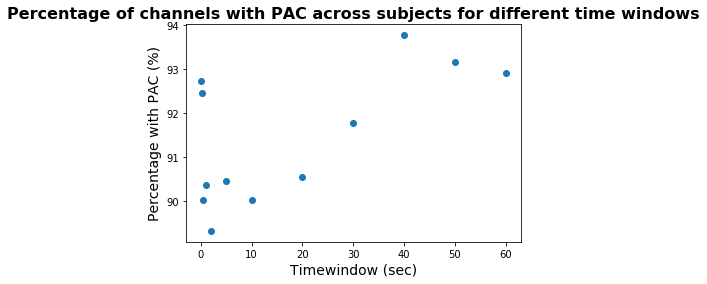

In [18]:
# Visualize 

fig = plt.figure()
plt.scatter(timewindows, scores)
# Add title, labels and legend
plt.title('Percentage of channels with PAC across subjects for different time windows', fontsize=16, fontweight='bold')
plt.xlabel('Timewindow (sec)', fontsize=14);
plt.ylabel('Percentage with PAC (%)', fontsize=14);

NameError: name 'subj' is not defined